<h2>Import necessary libraries</h2>

In [1]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import warnings
import re
import random
import os, hashlib
from keras.preprocessing import image
from keras import Model

from sklearn.cluster import KMeans

import warnings
import numpy
from PIL import Image
from sklearn.cluster import KMeans 
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA

<h2>Import data </h2>

In [2]:
PROJECT_DIR = ''
DATASET_PATH = PROJECT_DIR + 'dataset/Flowers/'

categories = ['Babi', 'Calimero', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("_",x).start()].capitalize() + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
categories_list = []


for category in categories:
    filenames = os.listdir(DATASET_PATH + category)    
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
#Shuffle the dataframe 
df = df.sample(frac=1).reset_index(drop=True)


In [3]:
df.head(10)

,filename,category
0,Tana/tana_413.jpg,Tana
1,Chrysanthemum/chrysanthemum_141.jpg,Chrysanthemum
2,Pingpong/pingpong_183.jpg,Pingpong
3,Babi/babi_152.jpg,Babi
4,Babi/babi_573.jpg,Babi
5,Lisianthus/lisianthus_848.jpg,Lisianthus
6,Babi/babi_329.jpg,Babi
7,Babi/babi_421.jpg,Babi
8,Babi/babi_585.jpg,Babi
9,Lisianthus/lisianthus_803.jpg,Lisianthus


Lisianthus/lisianthus_730.jpg


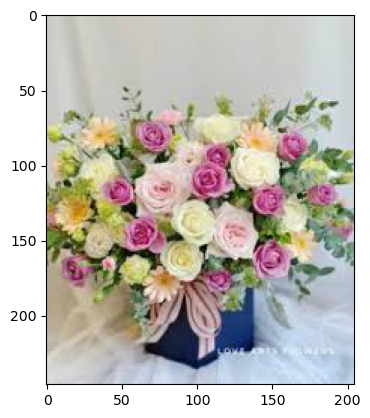

In [4]:
# Show random images
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = keras.utils.load_img(DATASET_PATH + sample['filename'])
print(sample['filename']) 
plt.imshow(randomimage)

<h2>EXPLORATORY DATA ANALYSIS </h2>

In [5]:
#finding duplicated files
duplicate_files = []
duplicates = []
hash_keys = dict()

for category in categories:
    folder = DATASET_PATH + category
    for _ , filename in  enumerate(os.listdir(folder)):
        with open(folder + '/' + filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
            file = folder + '/' + filename
        if filehash not in hash_keys: 
            hash_keys[filehash] = file
        else:
            duplicate_files.append(file)
            duplicates.append(category + '/' + filename)
            print("{}\t{}".format(file, hash_keys[filehash]))

dataset/Flowers/Babi/babi_197.jpg	dataset/Flowers/Babi/babi_196.jpg
dataset/Flowers/Babi/babi_223.jpg	dataset/Flowers/Babi/babi_222.jpg
dataset/Flowers/Babi/babi_236.jpg	dataset/Flowers/Babi/babi_235.jpg
dataset/Flowers/Babi/babi_244.jpg	dataset/Flowers/Babi/babi_243.jpg
dataset/Flowers/Babi/babi_418.jpg	dataset/Flowers/Babi/babi_357.jpg
dataset/Flowers/Babi/babi_423.jpg	dataset/Flowers/Babi/babi_422.jpg
dataset/Flowers/Babi/babi_426.jpg	dataset/Flowers/Babi/babi_342.jpg
dataset/Flowers/Babi/babi_450.jpg	dataset/Flowers/Babi/babi_372.jpg
dataset/Flowers/Babi/babi_490.jpg	dataset/Flowers/Babi/babi_483.jpg
dataset/Flowers/Babi/babi_495.jpg	dataset/Flowers/Babi/babi_442.jpg
dataset/Flowers/Babi/babi_528.jpg	dataset/Flowers/Babi/babi_338.jpg
dataset/Flowers/Babi/babi_570.jpg	dataset/Flowers/Babi/babi_365.jpg
dataset/Flowers/Babi/babi_75.jpg	dataset/Flowers/Babi/babi_221.jpg
dataset/Flowers/Babi/babi_785.jpg	dataset/Flowers/Babi/babi_774.jpg
dataset/Flowers/Babi/babi_811.jpg	dataset/Flowers

In [6]:
#drop all duplicates
for filename in duplicates:
    df.drop(df[df['filename'] == filename].index, inplace=True)

In [7]:
df['category'].value_counts()

Babi             907
Lisianthus       874
Chrysanthemum    679
Tana             523
Hydrangeas       512
Pingpong         353
Calimero         327
Rosy             161
Name: category, dtype: int64

<p>The number of images has the highest numbers of 907 and the lowest is 161 
</p>

In [8]:
print("Dataset : {}".format(df.shape[0]))

Dataset : 4336


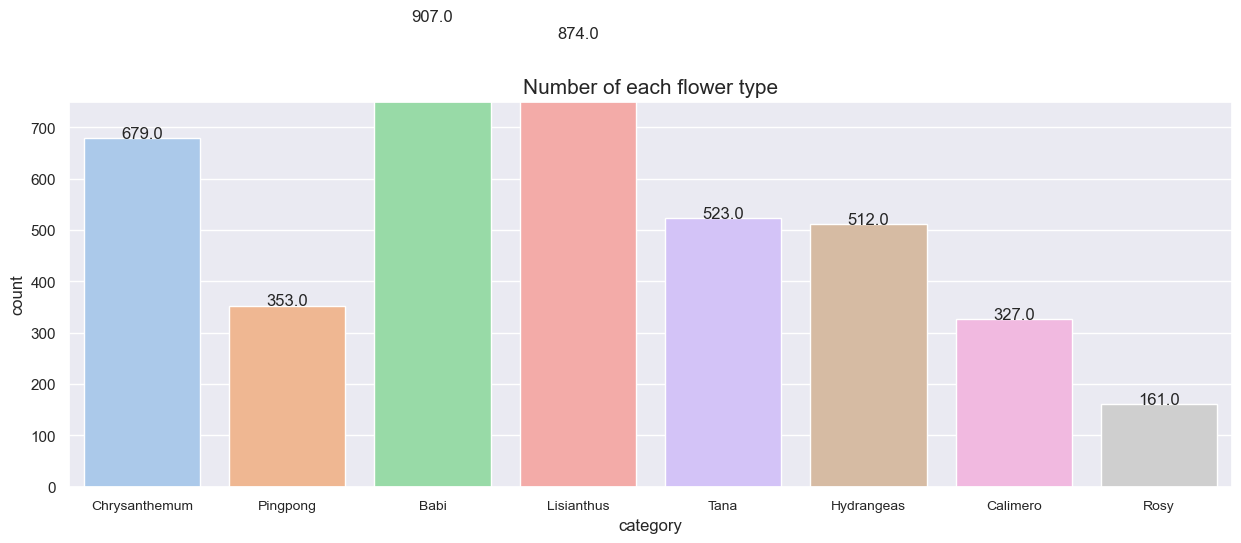

In [9]:
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize = (15 , 5))
graph = sns.countplot(ax=ax1,x='category', data=df, palette='pastel')
graph.set_title("Number of each flower type", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels(),rotation=0, fontsize=10)
ax1.set_ylim([0, 750])
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height, height, ha="center")

In [10]:
IMAGE_WIDTH = 160 #Declare image width
IMAGE_HEIGHT = 160 #Declare image height
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

Use CNN model in task 1 to support in extracting image features

In [11]:
# https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = ['accuracy', f1_m]

In [14]:
custom_objects = {"f1_m": f1_m}
model_alexnet = keras.models.load_model('saved/model_AlexNet.h5', custom_objects=custom_objects)
feature_extractor = Model(inputs=model_alexnet.inputs, outputs=model_alexnet.layers[-2].output)

In [15]:
image_list={}
for img in df['filename']:
    image = keras.utils.load_img(DATASET_PATH+img, target_size = IMAGE_SIZE)
    image = keras.utils.img_to_array(image)
    image = image.astype('float32')/255
    image = np.expand_dims(image, axis = 0)
    features = feature_extractor.predict(image)
    image_list[img]= features

1/1 [==============================] - 0s 26ms/step


In [17]:
print(len(image_list))

4336


In [45]:
filenames =np.array(list(image_list.keys()))

feat=np.array(list(image_list.values()))
feat_reshape = feat.reshape(-1, 1000)
print(feat_reshape.shape)

(4336, 1000)


Dimension reduction on dataframe for clustering algorithm is recommended.

In [46]:
tsne = TSNE(n_components=2, random_state=0)
x_tsne = tsne.fit_transform(feat_reshape)

In [47]:
pca = PCA(n_components=100, random_state=0)
x_pca = pca.fit_transform(feat_reshape)

In [48]:
x_tsne.shape

(4336, 2)

In [49]:
x_pca.shape

(4336, 100)

In [50]:
fig = px.scatter(x=x_tsne[:, 0], y=x_tsne[:, 1])
fig.update_layout(
    title="t-SNE visualization of Flower dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [51]:
fig = px.scatter(x=x_pca[:, 0], y=x_pca[:, 1])
fig.update_layout(
    title="PCA visualization of Flower dataset",
    xaxis_title="First PCA",
    yaxis_title="Second PCA",
)
fig.show()

From the figures of the 2 dimension reduction methods, we can see that T-SNE shows better clustering visualization.

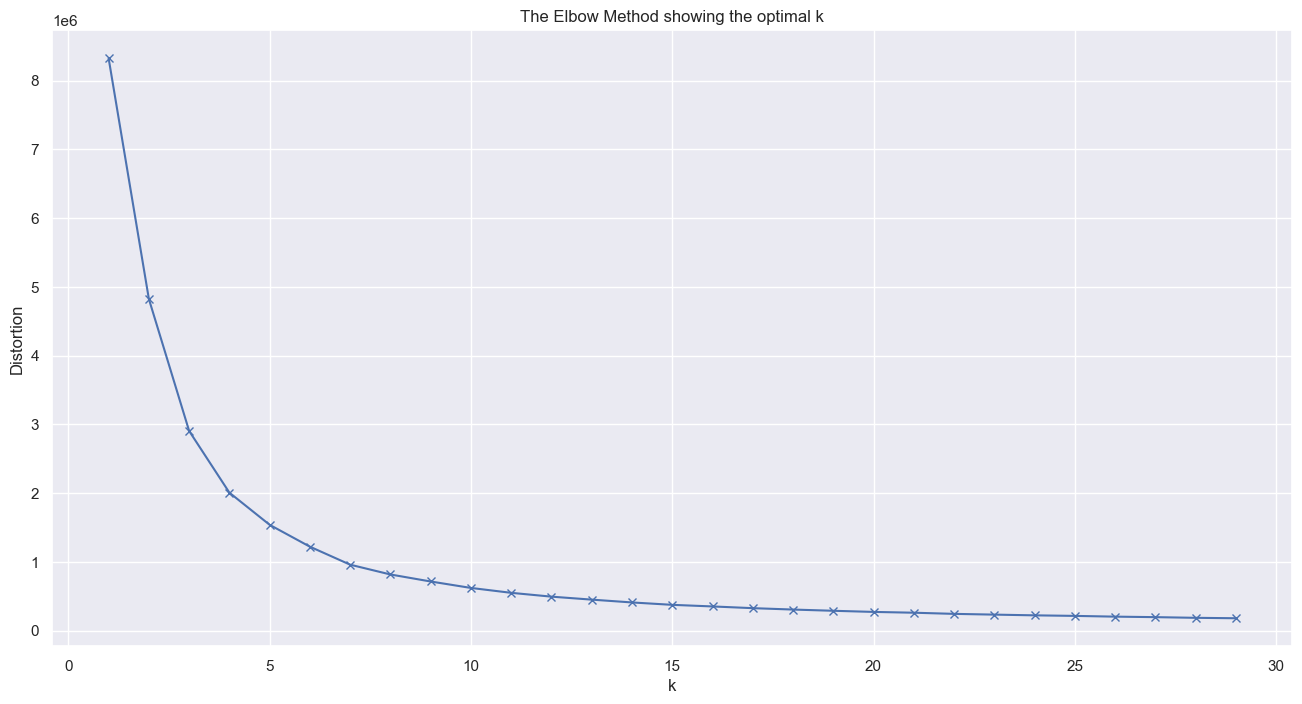

CPU times: total: 20.8 s
Wall time: 5.78 s


In [52]:
%%time
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x_tsne)
    distortions.append(kmeanModel.inertia_)    
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [53]:
kmeans = KMeans(n_clusters=8,random_state=0,max_iter=300,n_init=10,init='k-means++',algorithm='lloyd')
kmeans.fit(x_tsne)
cluster_labels=kmeans.predict(x_tsne)

In [54]:
print(metrics.silhouette_score(x_tsne, cluster_labels))

0.45247677


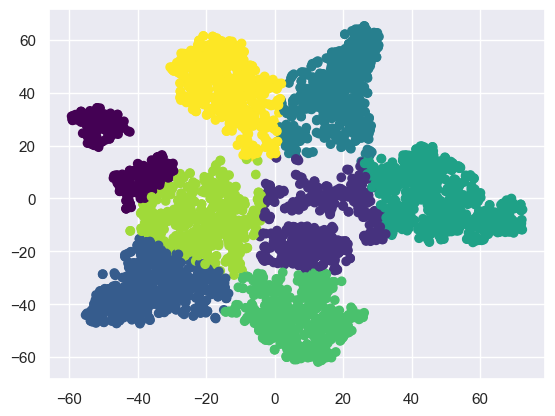

In [55]:
plt.scatter(x_tsne[:, 0], x_tsne[:,1], c =  cluster_labels, cmap= "viridis") # plotting the clusters
plt.show() # showing the plot

In [56]:
groups = {}

for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[int(cluster)] = []
        groups[int(cluster)].append(file)
    else:
        groups[int(cluster)].append(file)

In [59]:
def recommend_similar_images(image_path):
    image = keras.utils.load_img(image_path, target_size = IMAGE_SIZE)
    image = keras.utils.img_to_array(image)
    image = image.astype('float32')/255
    image = np.expand_dims(image, axis = 0)
    features = feature_extractor.predict(image)
    temp_feat = feat
    temp_feat = np.append(temp_feat, np.array([features]), axis=0)
    temp_feat = temp_feat.reshape(-1, 1000)
    temp_feat = tsne.fit_transform(temp_feat)
    prediction = kmeans.predict(temp_feat)
    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    
    for i in range(10):
        random_image = random.choice(groups[prediction[-1]])
        img = cv2.imread(DATASET_PATH + random_image)
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(random_image)
        
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
    plt.show()


1/1 [==============================] - 0s 22ms/step
Tana/tana_521.jpg
Chrysanthemum/chrysanthemum_609.jpg
Tana/tana_2.jpg
Tana/tana_309.jpg
Tana/tana_108.jpg
Tana/tana_41.jpg
Tana/tana_599.jpg
Tana/tana_40.jpg
Tana/tana_373.jpg
Tana/tana_18.jpg


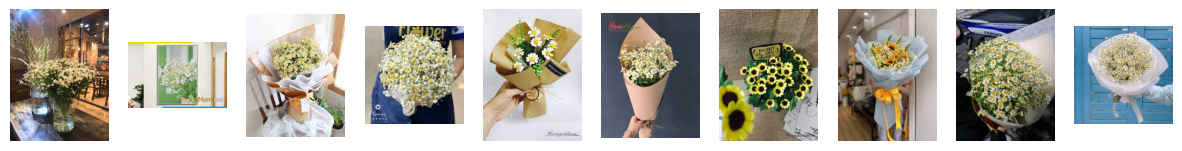

In [61]:
recommend_similar_images('./test_image.jpg')

<h3>DBSCAN</h3>

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

In [106]:
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(x_tsne) # fitting the data to the object
distances,indices=nbrs.kneighbors(x_tsne) # finding the nearest neighbours

Find out the epsilon points for DBSCAN

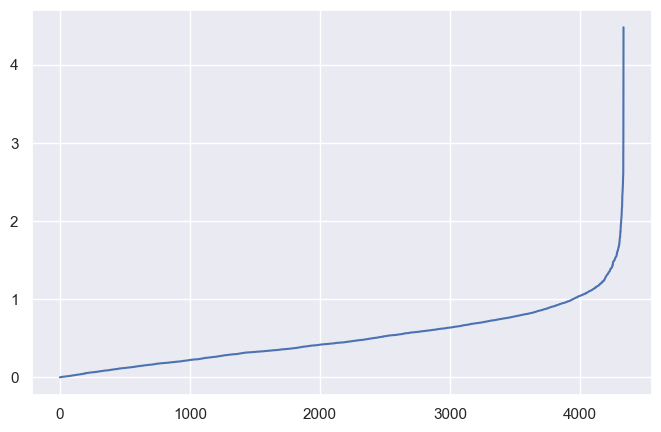

In [107]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (8,5) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [108]:
# instantiating DBSCAN
dbscan = DBSCAN(eps=1.8, min_samples=15)
# fitting model
model = dbscan.fit(x_tsne)

In [109]:
labels = model.labels_

In [110]:
# identify core samples
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
print(core_samples)

[False False False ... False False False]


In [111]:
# declare the number of clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)

11


In [112]:
print(metrics.silhouette_score(x_tsne, labels))

-0.4961874


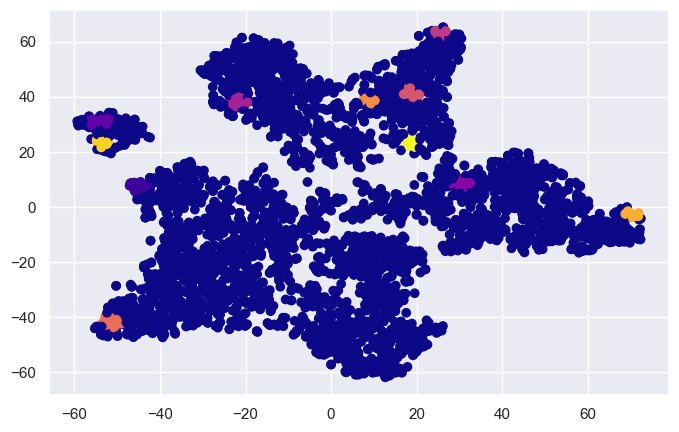

In [113]:
plt.scatter(x_tsne[:, 0], x_tsne[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.show() # showing the plot

In [114]:
import joblib

joblib.dump(kmeans, "model/model_kmeans.joblib")

['model/model_kmeans.joblib']

In [115]:
joblib.dump(feat, "model/feat.data")

['model/feat.data']

In [116]:
joblib.dump(groups, "model/groups.data")

['model/groups.data']